## Level 8: Unit sales of all products, aggregated for each store and category

In [3]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

***

In [10]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["store_id","cat_id","ds"])
        .agg({"q":"sum",
              "state_id":lambda x: int(x.unique()),
              "snap":lambda x: int(x.unique()),
              "event_name_1":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["store_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [11]:
weights_level8 = pd.read_parquet("../input/weights_level8.parquet")
weights_level8.head()

,store_id,cat_id,weight
0,1,3,0.061961
1,1,1,0.017810
2,1,2,0.031118
3,2,3,0.060341
4,2,1,0.012275


In [12]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["store_id","cat_id"]).rename({"q":"s"}, axis=1)
scales.head()

,store_id,cat_id,s
0,1,1,125.624507
1,1,2,191.084687
2,1,3,618.378355
3,2,1,107.108753
4,2,2,259.893734


In [13]:
weights = (weights_level8
    .merge(scales, how="inner", on=["store_id","cat_id"])
    .assign(weight = lambda x: x.weight/x.s)
    .assign(weight = lambda x: x.weight/x.weight.median())
    .drop(["s"], axis=1)
)
weights.head()

,store_id,cat_id,weight
0,1,3,0.725278
1,1,1,1.026185
2,1,2,1.178773
3,2,3,0.980720
4,2,1,0.829537


In [14]:
data = pd.merge(data, weights, how="left", on=["store_id","cat_id"])
data.head()

,store_id,cat_id,ds,y,state_id,snap,event_name_1,weight
0,1,1,2011-01-29,556,1,0,1,1.026185
1,1,2,2011-01-29,542,1,0,1,1.178773
2,1,3,2011-01-29,3239,1,0,1,0.725278
3,1,1,2011-01-30,498,1,0,1,1.026185
4,1,2,2011-01-30,520,1,0,1,1.178773


***
### time series visualization

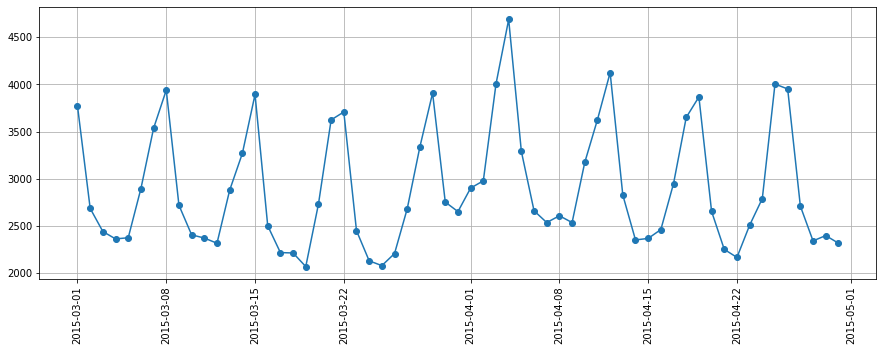

In [28]:
store_id = 1
cat_id = 3
start_date = '2015-03-01'
end_date = '2015-04-30'

df = data.query("store_id == @store_id & cat_id ==@cat_id & @start_date <= ds <= @end_date")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-")
plt.xticks(rotation=90)
plt.grid()
plt.show()

***

In [29]:
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
                 (pd.to_datetime("2016-01-29"), pd.to_datetime("2016-02-26")),
                 (pd.to_datetime("2016-02-27"), pd.to_datetime("2016-03-26")),
                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")),
                ]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')),
 (Timestamp('2016-01-29 00:00:00'), Timestamp('2016-02-26 00:00:00')),
 (Timestamp('2016-02-27 00:00:00'), Timestamp('2016-03-26 00:00:00')),
 (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [30]:
model_params = {
    'objective':'l2',
    'metric':'None',
    'num_iterations':10000,
    'early_stopping_rounds':250,
    #'max_bin': 255,
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'min_data_in_leaf': 20,
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.66,
    'bagging_fraction':0.9,
    'bagging_freq':1,
    'lambda_l2':1.,
    'seed':23
}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    "week_day_cos",
    "week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    "month_cos",
    "month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "store_id":"default",
        "cat_id":"default",
        "state_id":"default",
        "event_name_1":"default",
        "snap":"default"},
    "ts_uid_columns":["store_id","cat_id"],  
}

In [31]:
# 4+ years of history
train_history = 1800

In [33]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data,
                                                        _valid_index,
                                                        ts_uid_columns=["store_id","cat_id"])

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level8, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/5 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 30/30 [00:00<00:00, 32.41it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.593176
[50]	valid_0's wrmsse: 0.51978
[75]	valid_0's wrmsse: 0.499327
[100]	valid_0's wrmsse: 0.495511
[125]	valid_0's wrmsse: 0.491476
[150]	valid_0's wrmsse: 0.481842
[175]	valid_0's wrmsse: 0.478971
[200]	valid_0's wrmsse: 0.476045
[225]	valid_0's wrmsse: 0.475291
[250]	valid_0's wrmsse: 0.475029
[275]	valid_0's wrmsse: 0.472203
[300]	valid_0's wrmsse: 0.470576
[325]	valid_0's wrmsse: 0.468122
[350]	valid_0's wrmsse: 0.466791
[375]	valid_0's wrmsse: 0.46531
[400]	valid_0's wrmsse: 0.464807
[425]	valid_0's wrmsse: 0.462815
[450]	valid_0's wrmsse: 0.462029
[475]	valid_0's wrmsse: 0.460864
[500]	valid_0's wrmsse: 0.459956
[525]	valid_0's wrmsse: 0.458519
[550]	valid_0's wrmsse: 0.458149
[575]	valid_0's wrmsse: 0.457314
[600]	valid_0's wrmsse: 0.457008
[625]	valid_0's wrmsse: 0.456689
[650]	valid_0's wrmsse: 0.45607
[675]	valid_0's wrmsse: 0.457605
[700]	valid_0's wrmsse: 0.456947
[725]	valid_0's wrms

100%|██████████| 30/30 [00:00<00:00, 33.65it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.793949
[50]	valid_0's wrmsse: 0.732222
[75]	valid_0's wrmsse: 0.707607
[100]	valid_0's wrmsse: 0.692367
[125]	valid_0's wrmsse: 0.682961
[150]	valid_0's wrmsse: 0.678626
[175]	valid_0's wrmsse: 0.675112
[200]	valid_0's wrmsse: 0.670785
[225]	valid_0's wrmsse: 0.668442
[250]	valid_0's wrmsse: 0.666424
[275]	valid_0's wrmsse: 0.663349
[300]	valid_0's wrmsse: 0.660895
[325]	valid_0's wrmsse: 0.657676
[350]	valid_0's wrmsse: 0.656971
[375]	valid_0's wrmsse: 0.653851
[400]	valid_0's wrmsse: 0.651273
[425]	valid_0's wrmsse: 0.650207
[450]	valid_0's wrmsse: 0.648955
[475]	valid_0's wrmsse: 0.647748
[500]	valid_0's wrmsse: 0.646589
[525]	valid_0's wrmsse: 0.645404
[550]	valid_0's wrmsse: 0.643918
[575]	valid_0's wrmsse: 0.643213
[600]	valid_0's wrmsse: 0.642405
[625]	valid_0's wrmsse: 0.641509
[650]	valid_0's wrmsse: 0.64038
[675]	valid_0's wrmsse: 0.638621
[700]	valid_0's wrmsse: 0.63744
[725]	valid_0's wrm

100%|██████████| 30/30 [00:00<00:00, 32.01it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.847603
[50]	valid_0's wrmsse: 0.787729
[75]	valid_0's wrmsse: 0.752649
[100]	valid_0's wrmsse: 0.730004
[125]	valid_0's wrmsse: 0.717987
[150]	valid_0's wrmsse: 0.711059
[175]	valid_0's wrmsse: 0.707167
[200]	valid_0's wrmsse: 0.701785
[225]	valid_0's wrmsse: 0.699714
[250]	valid_0's wrmsse: 0.693614
[275]	valid_0's wrmsse: 0.694592
[300]	valid_0's wrmsse: 0.694729
[325]	valid_0's wrmsse: 0.694014
[350]	valid_0's wrmsse: 0.691751
[375]	valid_0's wrmsse: 0.689872
[400]	valid_0's wrmsse: 0.689955
[425]	valid_0's wrmsse: 0.68947
[450]	valid_0's wrmsse: 0.688727
[475]	valid_0's wrmsse: 0.688787
[500]	valid_0's wrmsse: 0.686815
[525]	valid_0's wrmsse: 0.686509
[550]	valid_0's wrmsse: 0.685534
[575]	valid_0's wrmsse: 0.68459
[600]	valid_0's wrmsse: 0.684024
[625]	valid_0's wrmsse: 0.683739
[650]	valid_0's wrmsse: 0.683646
[675]	valid_0's wrmsse: 0.682333
[700]	valid_0's wrmsse: 0.680908
[725]	valid_0's wrm

100%|██████████| 30/30 [00:00<00:00, 32.02it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.879367
[50]	valid_0's wrmsse: 0.814837
[75]	valid_0's wrmsse: 0.778756
[100]	valid_0's wrmsse: 0.757719
[125]	valid_0's wrmsse: 0.750611
[150]	valid_0's wrmsse: 0.742272
[175]	valid_0's wrmsse: 0.733691
[200]	valid_0's wrmsse: 0.728183
[225]	valid_0's wrmsse: 0.725626
[250]	valid_0's wrmsse: 0.720828
[275]	valid_0's wrmsse: 0.715823
[300]	valid_0's wrmsse: 0.714306
[325]	valid_0's wrmsse: 0.713265
[350]	valid_0's wrmsse: 0.709411
[375]	valid_0's wrmsse: 0.708187
[400]	valid_0's wrmsse: 0.705789
[425]	valid_0's wrmsse: 0.705685
[450]	valid_0's wrmsse: 0.701759
[475]	valid_0's wrmsse: 0.701772
[500]	valid_0's wrmsse: 0.701066
[525]	valid_0's wrmsse: 0.69924
[550]	valid_0's wrmsse: 0.696078
[575]	valid_0's wrmsse: 0.6948
[600]	valid_0's wrmsse: 0.691608
[625]	valid_0's wrmsse: 0.689595
[650]	valid_0's wrmsse: 0.686872
[675]	valid_0's wrmsse: 0.685693
[700]	valid_0's wrmsse: 0.68123
[725]	valid_0's wrmss

100%|██████████| 30/30 [00:00<00:00, 32.15it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.790737
[50]	valid_0's wrmsse: 0.691892
[75]	valid_0's wrmsse: 0.643438
[100]	valid_0's wrmsse: 0.615871
[125]	valid_0's wrmsse: 0.608981
[150]	valid_0's wrmsse: 0.60584
[175]	valid_0's wrmsse: 0.605917
[200]	valid_0's wrmsse: 0.61128
[225]	valid_0's wrmsse: 0.608497
[250]	valid_0's wrmsse: 0.60899
[275]	valid_0's wrmsse: 0.609296
[300]	valid_0's wrmsse: 0.609588
[325]	valid_0's wrmsse: 0.609985
[350]	valid_0's wrmsse: 0.611679
[375]	valid_0's wrmsse: 0.611595
Early stopping, best iteration is:
[149]	valid_0's wrmsse: 0.603701


In [34]:
np.mean(errors)

0.593457111769623

***
### training final model

In [13]:
model_kwargs["model_params"]["num_iterations"] = int(np.median(best_iterations))
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'None',
 'num_iterations': 1218,
 'early_stopping_rounds': 250,
 'num_leaves': 31,
 'learning_rate': 0.05,
 'min_data_in_leaf': 20,
 'feature_fraction': 0.66,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'lambda_l2': 1.0,
 'seed': 23}

In [ ]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(train_data,
                                                        ts_uid_columns=["store_id"])
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

100%|██████████| 10/10 [00:00<00:00, 17022.34it/s]


***
### prediction

In [ ]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, ["ds","store_id","state_id","event_name_1","snap"]]
                   .drop_duplicates()
                   .merge(weights, how="left", on="store_id"))
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, ["ds","store_id","state_id","event_name_1","snap"]]
                  .drop_duplicates()
                  .merge(weights, how="left", on="store_id"))

In [ ]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, valid_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [ ]:
forecast

***